<a href="https://colab.research.google.com/github/Lenflammeur/UCL-MSc_Project/blob/main/TCN_TimeSeries_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Library

In [25]:
import wget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
import tensorflow as tf

from tcn import TCN

In [2]:
wget.download("https://github.com/philipperemy/keras-tcn/raw/master/tasks/monthly-milk-production-pounds-p.csv")

'monthly-milk-production-pounds-p.csv'

### Read the dataset

In [3]:
milk = pd.read_csv('monthly-milk-production-pounds-p.csv', index_col=0, parse_dates=True)

### Display top5 Record

In [4]:
print(milk.shape)
milk.head()

(168, 1)


,milk_production_pounds
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


### Lookback 12 month windows

In [5]:
lookback_window = 12 

### Convert Milk Data into Numpy Array

In [6]:
milk = milk.values  

### Convert in to X, y format

In [7]:
x = []
y = []
for i in tqdm(range(lookback_window, len(milk))):
    x.append(milk[i - lookback_window:i])
    y.append(milk[i])

  0%|          | 0/156 [00:00<?, ?it/s]

### Generate Array of list x and y

In [8]:
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(156, 12, 1)
(156, 1)


### Model Design

In [44]:
i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 12, 1)]           0         
_________________________________________________________________
tcn_6 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile('adam','mae')

### Time for Model training...

In [37]:
print('Train...')
model.fit(x, y, epochs=100)

Train...
Epoch 1/100
5/5 [==============================] - 3s 17ms/step - loss: 5171.7063
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1048.6255
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 356.5305
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 538.0238
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 227.6653
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 156.1743
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 160.2109
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 104.9422
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 176.1735
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 145.5191
Epoch 11/100
5/5 [==============================] - 0s 16ms/step - loss: 140.8532
Epoch 12/100
5/5 [==============================] - 0s 16ms/step - loss: 137.3899
Epoch 13/100
5

### Prediction with TCN Model

In [38]:
predict = model.predict(x)

### Plot the Result

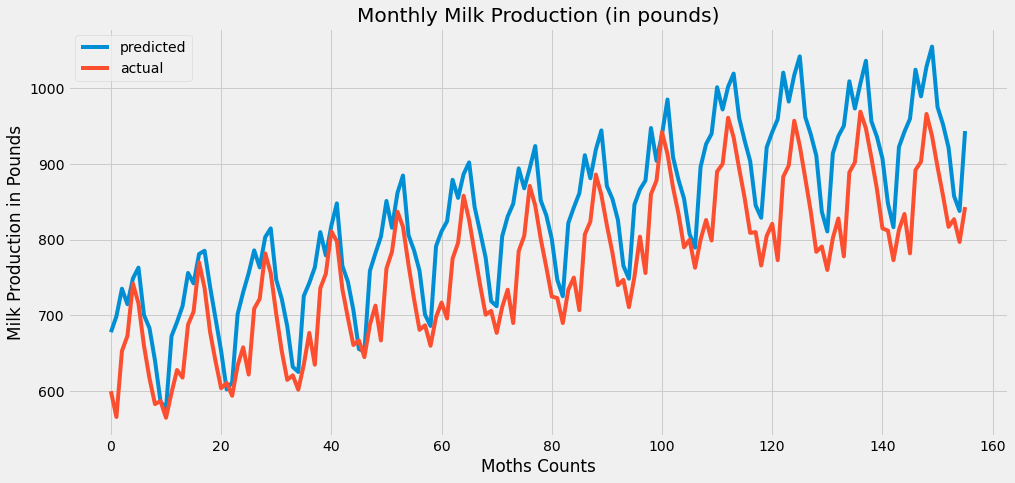

In [39]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(predict)
plt.plot(y)
plt.title('Monthly Milk Production (in pounds)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Moths Counts")
plt.ylabel("Milk Production in Pounds")
plt.show()

In [54]:
from tensorflow.keras.layers import UpSampling1D
from tensorflow import keras

In [59]:
model_inverse = keras.models.Sequential()
model_inverse.add(keras.layers.InputLayer(input_shape=[1, 1]))
model_inverse.add(keras.layers.UpSampling1D(64))
model_inverse.add(TCN())
model_inverse.add(keras.layers.Dense(12, activation='linear'))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 12, 1)]           0         
_________________________________________________________________
tcn_6 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


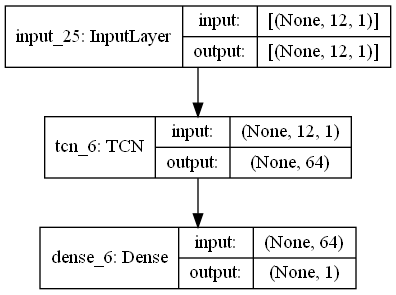

In [60]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)